In [9]:
pip install dash

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import collections
from collections import OrderedDict
import ast
import plotly.express as px
from dash import Dash, dcc, html
from wordcloud import WordCloud
import numpy as np

In [11]:
pd.set_option('display.max_colwidth', 10,)
pd.set_option('display.max_rows', 50,)

In [13]:
df = pd.read_csv('games_detailed_info.csv', index_col=0)

<ipython-input-13-21af5343c777>:1: DtypeWarning: Columns (29,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('games_detailed_info.csv', index_col=0)


### 1. Pandas

##### 1. Проверить данные на наличие пропусков и заполнить их (обосновать выбор метода для заполнения)

Смотрим сколько пропусках в колонках

Смотрим в каких колонках пропуски

In [14]:
df.isnull().sum()

,0
type,0
id,0
thumbnail,15
image,15
primary,0
...,...
Video Game Rank,21630
Amiga Rank,21630
Commodore 64 Rank,21630
Arcade Rank,21630


В некоторых колонках более 50% данных NAN, поэтому дропаем их.

In [15]:
perc = df.isnull().sum()/len(df)
df = df.drop(perc[perc>=0.5].keys(), axis=1)

Также некоторые колонки содержат непонятно что и в названии и по описанию на kaggle

In [16]:
df = df.drop(['average','bayesaverage','stddev','median', 'numweights'], axis=1)

Заполняем данные, которые понадобятся позже

In [17]:
df.fillna(
    {
        "boardgameartist": "['Anonymous Artists']",
        "boardgamemechanic": "['Unknown']"
    },
    inplace=True,
)

##### 2. Проверить данные на наличие выбросов (аномально высоких или низких значений) и устранить выбросы при наличии (обосновать метод для обнаружения выбросов).

У этих данных вообще возможны выбросы ( у дргих либо строки, либо занчения, у которых нет ограничений, например рейтинг)
У времени игры везде есть один выброс, по идее это все одна и таже игра. Ее и уберем.

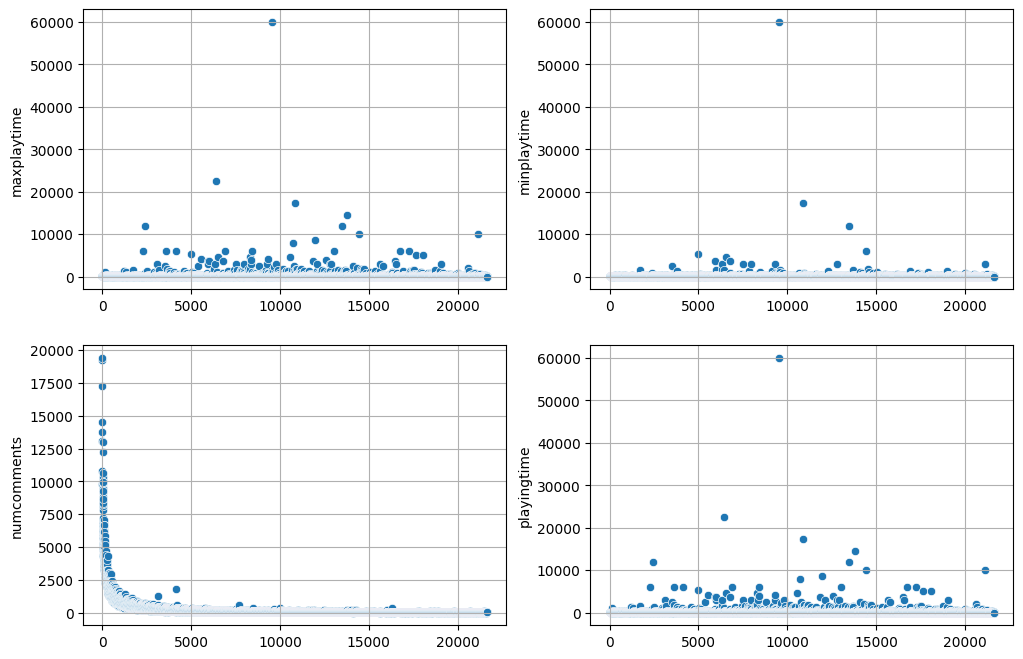

<Figure size 700x500 with 0 Axes>

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

plt.figure(figsize=(7, 5))

sns.scatterplot( data=df['maxplaytime'], ax = axs[0,0])
sns.scatterplot( data=df['minplaytime'], ax = axs[0,1])
sns.scatterplot( data=df['numcomments'], ax = axs[1,0])
sns.scatterplot( data=df['playingtime'], ax = axs[1,1])

axs[0,0].grid(True)
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
plt.tight_layout()
plt.show()

In [19]:
df = df.drop(df['maxplaytime'].idxmax())

##### 3. Произвести фильтрацию.

**Гипотеза**: Для настолок с минимальным возрастом меньше 12 лет, время среднее игры будет короче

**Ответ**: Это правда, и почти в три раза!


In [20]:
print(df.loc[df['minage'] < 12]['playingtime'].mean())
print(df.loc[df['minage'] >= 12]['playingtime'].mean())

52.61282861768561
140.35835546829887


##### 4. Произвести группировку.
Вы группируете сериалы по оценкам и смотрите на их количество, чтобы подтвердить гипотезу о том, что люди в среднем ставят больше всего оценок "хорошо".

**Вопрос**: Настолки с каким количеством художников и количеством механик встречаются чаще всего?

**Ответ**: Одиночки и с одной механикой наиболее популярны

In [21]:
df['boardgameartist'] = [ast.literal_eval(i) for i in df['boardgameartist']]  # Переводим из строки в массив
df['boardgamemechanic'] = [ast.literal_eval(i) for i in df['boardgamemechanic']]
df['count_artists'] = df['boardgameartist'].transform(len)  # Создаем дополнительную колонку с количеством художников
df['count_mechanics'] = df['boardgamemechanic'].transform(len)

In [22]:
rating_mechanics = df.loc[~df['boardgameartist'].isin([['Anonymous Artists']] & ~df['boardgamemechanic'].isin([['Unknown']]))][['count_artists', 'count_mechanics']].value_counts().reset_index() # Убираем анонимусов

rating_mechanics.loc[rating_mechanics.groupby(['count_artists'])['count'].idxmax()].head(5) # Смотрим на топ 5

<ipython-input-22-693d64d7e56f>:1: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  rating_mechanics = df.loc[~df['boardgameartist'].isin([['Anonymous Artists']] & ~df['boardgamemechanic'].isin([['Unknown']]))][['count_artists', 'count_mechanics']].value_counts().reset_index() # Убираем анонимусов


,count_artists,count_mechanics,count
0,1,1,4986
5,2,2,721
12,3,2,262
21,4,2,106
28,5,3,55


##### 5. Проанализировать строковые данные.
Вы хотите посмотреть, зависит ли оценка сериала от длины его названия.

**Вопрос** : Больше ли людей хотят настолку, если у нее длинное описание?

**Ответ** : Это правда

In [23]:
# Создаем отдельную колонку с длиной описания

df['descriptionlength'] = df['description'].str.len()

In [24]:
# Топ-10 игр в виш-листах

df.sort_values(['wishing'], ascending = True)[['wishing', 'descriptionlength']].tail(10).mean()

,0
wishing,15207.5
descriptionlength,2163.0


In [25]:
# Антитоп-10 игр в виш-листах

df.sort_values(['wishing'], ascending = True)[['wishing', 'descriptionlength']].head(10).mean()

,0
wishing,0.0
descriptionlength,636.5


In [26]:
760.8 < 2163

True

##### 6. Проанализировать временные данные.
**Вопрос**: В каком пятилетии вышло больше всего настолок?

**Ответ**: в 2015-2020 году

In [27]:
print(pd.Timestamp.min)
print(pd.Timestamp.max)  # Datetime поддреживает только такой промежуток времени, поэтому пришлось взять с 1677 года

1677-09-21 00:12:43.145224193
2262-04-11 23:47:16.854775807


In [28]:
# Сложными махинациями переводим в формат Datetime
years = pd.to_datetime(df.drop(df[df['yearpublished'] <= 1677].index)['yearpublished'].astype(str) + '-01-01').to_frame()

five_years = (years['yearpublished'].dt.year // 5) * 5 # Поделить на пятилетия
df_filtered = years['yearpublished'].dt.year.to_frame() # Датафрейм-счетчик

df_filtered['five_year'] = five_years
fives = df_filtered.groupby('five_year')['yearpublished'].count().reset_index(name='count').sort_values('count')
five_max = fives.max()

print(fives)
print('За все время', fives.max())

    five_year  count
16       1830      1
1        1685      1
3        1715      1
24       1875      1
5        1745      1
..        ...    ...
53       2020   1690
49       2000   1840
50       2005   2803
51       2010   4137
52       2015   6342

[54 rows x 2 columns]
За все время five_year    2020
count        6342
dtype: int64


In [29]:
df['year'] = df_filtered['yearpublished'] # Сохраняем на потом

### 2. Визуализация

##### 1. Линейный (plot) или точечный (scatter) график.
Один или больше.



**Вопрос** :  Чем выше место в рейтинге, тем больше будет комментариев

In [30]:
df_board = df[df['Board Game Rank'] != 'Not Ranked']

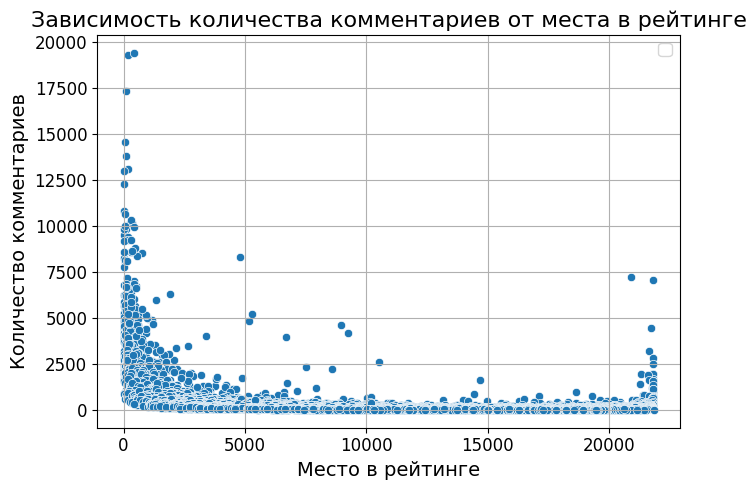

In [31]:
hyp1 = df_board[['numcomments', 'Board Game Rank']]

plt.figure(figsize=(7, 5))

sns.scatterplot(x="Board Game Rank", y="numcomments", data=hyp1)

plt.title('Зависимость количества комментариев от места в рейтинге', fontsize=16)
plt.xlabel('Место в рейтинге', fontsize=14)
plt.ylabel('Количество комментариев', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()

#####  2. Столбчатые (bar) диаграммы.
Две или больше.

**Вопрос** На сколько соотносится  среднее значение игроков в одной партии и реального оптимального количества из данных от комьюнити

In [32]:
df['suggested_num_players'] = [eval(i) for i in df['suggested_num_players']]  #  Так делать очень плохо но без понятия как еще json.loads не работает

In [33]:
df['suggested_num_players']

,suggested_num_players
0,[{'@nu...
1,[{'@nu...
2,[{'@nu...
3,[{'@nu...
4,[{'@nu...
...,...
21626,[{'@nu...
21627,[{'@nu...
21628,[{'@nu...
21629,[{'@nu...


In [34]:
def plus(x: str) -> int:  #  Собираем данные из сортированных словарей
    if '+' in x:
        return int(x.replace('+', ''))
    return int(x)
for i in df.index:
    max_votes_info = []
    data = df['suggested_num_players'][i]
    if isinstance(data, collections.OrderedDict):
        df.loc[i, 'ideal_num_players'] = plus(data['@numplayers'])
    else:
        for item in data:
            num_players = item['@numplayers']
            max_votes = max(int(result['@numvotes']) for result in item['result'])
            max_votes_info.append((num_players, max_votes))
            num_players_with_max_votes = max(max_votes_info, key=lambda x: x[1])[0]
            df.loc[i, 'ideal_num_players'] = plus(num_players_with_max_votes)


In [35]:
df['averagenumplayers'] = (df['maxplayers'] + df['minplayers'])//2 # Создаем новую колонку со ср. игроков от разрабов

In [36]:
df['ratenumplayers'] = (df['ideal_num_players'] - 1 <= df['averagenumplayers']) & (df['averagenumplayers'] <= df['ideal_num_players'] + 1) # Даем погрешность 1 в обе стороны

In [37]:
players = df.groupby('ideal_num_players').size().sort_values().reset_index(name = 'count')

In [65]:
fig = px.bar(df, x='ratenumplayers')
fig.update_traces(marker_color = 'rgba(0,0,250, 0.5)',
                  marker_line_width = 0,
                  selector=dict(type="bar"))
fig.update_layout(
    title="Соответсвие ожидаемого идеального количества игроков с реальностью",
    width=1000,
    height=1000,
    xaxis_title='Соответсвие',
    yaxis_title='Количество'
)
fig.show()

##### 3. Круговая (pie) диаграмма.
Одна или больше.

**Вопрос** : Каковы доли различных игровых категорий? Какие чаще всего встречаются?

In [39]:
df_category = df.dropna(subset='boardgamecategory')

In [40]:
df_category['boardgamecategory'] = [eval(str(i)) for i in df_category['boardgamecategory']]

<ipython-input-40-bea1741d93ce>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
df_category = df_category['boardgamecategory'].explode().value_counts().reset_index() # Подсчёт



In [42]:
fig = px.pie(df_category, values='count', names='boardgamecategory')
fig.update_layout(
    title="Board game categories",
    width=1000,  # Width in pixels
    height=1000   # Height in pixels
)
fig.show()

#####  4. Гистограмма (displot / histplot от seaborn или hist от matplotlib).
Одна или больше.

**Гипотеза**: Сложность игры зависит от самого младшего игрока

In [43]:
data = df.groupby('minage', as_index=False)['averageweight'].mean()

In [44]:
fig = px.histogram(
    data,
    x='minage',
    y='averageweight',
    title='Средняя сложность игры от минимального возраста игрока',
    labels={'minage': 'Минимальный возраст', 'averageweight': 'Сложность игры'}
)
fig.update_layout(bargap=0.2)
fig.update_traces(xbins_size = 1)


fig.show()

#####  5. Хитмэп (heatmap).
Один или больше.


**Гипотеза**: Понимание языка (на картых и других реквизитах) делает игру легче

In [45]:
df = df.dropna(subset = ['suggested_language_dependence']) # Убираем nan

In [46]:
df['suggested_language_dependence'] = [eval(str(i)) for i in df['suggested_language_dependence']]  # Приводим к нужному типу данныхххх

In [47]:
def find_lang(ordered_dicts):
    max_entry = max(ordered_dicts, key=lambda x: int(x['@numvotes']))
    return max_entry['@value']

df['language_dependence'] = df['suggested_language_dependence'].apply(find_lang) # Новая колонка с оценкой (в  виде текста)

In [48]:
df_heatmap = df[['language_dependence', 'averageweight']]

In [49]:
fig = px.density_heatmap(
    df_heatmap,
    y='language_dependence',
    x='averageweight',
)

fig.update_layout(
    title='Зависимость сложности игры от важности языка в игре',
    yaxis_title="Зависимость от языка",
    xaxis_title="Сложность игры",

)

fig.show()

#####  6. Облако слов.
Два или больше.

**Вопрос**: Какие слова встречаются у настолки с наибольшим описанием?

In [50]:
long_desc = df.loc[df['descriptionlength'].idxmax()]['description']

In [51]:
df.loc[df['descriptionlength'].idxmax()][['Board Game Rank', 'primary']]

,21627
Board Game Rank,15017
primary,BABEL


In [52]:
wordcloud = WordCloud(width=800, height=400).generate(long_desc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')
plt.close()
fig = px.imshow(np.array(wordcloud.to_image()))
fig.update_layout(title='Longest description word cloud', xaxis_visible=False, yaxis_visible=False)

fig.show()

**Вопрос** : Какие категории встерчаются чаще всего?

In [53]:
freq = df_category.groupby('boardgamecategory').count().to_dict(orient='dict')['count']


In [54]:
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.savefig('freqcloud.png')
plt.close()
fig = px.imshow(np.array(wordcloud2.to_image()))
fig.update_layout(title='Категории игр', xaxis_visible=False, yaxis_visible=False)

3D scatterplot

**Вопрос**: Как соотносится фидбэк к игре к году выпуска игры?

In [55]:
data = df.loc[df['year'] > 2000][['trading','wishing','owned', 'year']]

In [66]:
app = Dash(__name__)

fig = px.scatter_3d(
    data,
    x='owned',
    y='trading',
    z='wishing',
    color="year"
)
app.layout = html.Div([
    html.H4('Настолки по годам и фидбэки аудитории'),
    dcc.Graph(id="graph", figure=fig)
])

app.run_server(debug=True)


<IPython.core.display.Javascript object>